In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.formula.api import ols
    

Using TensorFlow backend.


Read the csv file.

In [2]:
data = pd.read_csv("C:/Users/kimbe/Bikeshare/Data/hourly.csv")

## Exploratory Data Analysis

#### 1. Show the number of rows and columns

In [3]:
row_count = len(data)
column_count = len(data.columns)

In [4]:
row_count

17379

In [5]:
column_count

17

#### 2. Show the type of each column

In [6]:
data.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

#### 3. Show the first few rows

In [7]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### 4. Check to see if there is any missing values.

In [8]:
data.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

## Data Wrangling

Looking at the data, it seems like there are some columns that need to be converted to object type as they are not numeric variables.

In [9]:
data["season"] = data["season"].astype(object) 
data["yr"] = data["yr"].astype(object) 
data["mnth"] = data["mnth"].astype(object)
data["hr"] = data["hr"].astype(object) 
data["holiday"] = data["holiday"].astype(object) 
data["weekday"] = data["weekday"].astype(object) 
data["workingday"] = data["workingday"].astype(object) 
data["weathersit"] = data["weathersit"].astype(object) 

In [10]:
data.dtypes

instant         int64
dteday         object
season         object
yr             object
mnth           object
hr             object
holiday        object
weekday        object
workingday     object
weathersit     object
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

Split into train and test sets.

In [11]:
X = data.drop(["cnt"], axis=1)
y = data["cnt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Variable Selection

Since *cnt* is the sum of *casual* and *registered*, *casual* and *registered* will not be used. Also, *instant* and *dteday* are not useful in this case.

In [12]:
X_train.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered'],
      dtype='object')

In [13]:
X_train = X_train[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]

In [14]:
X_train.columns

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')

Combine to use for variable selection below.

In [15]:
train = pd.concat([X_train, y_train], axis=1)

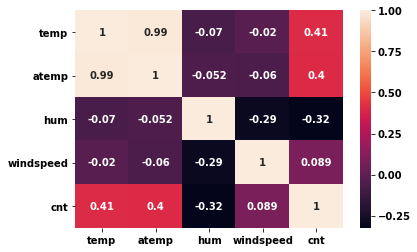

In [16]:
data_num = train[["temp", "atemp", "hum", "windspeed", "cnt"]]
corrMatrix = data_num.corr()
sns.heatmap(corrMatrix, annot=True)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() 

From the correlation matrix above, we can see that *temp* and *atemp* are highly correlated, so only one of the two variables will be used. We can also see that *windspeed* is not signficant to *cnt*, so we will also exclude that variable.

OLS is used below to see which variables are still significant when they are put together.

In [17]:
fit = ols('cnt ~ C(season) + C(yr) + C(mnth) + C(hr) + C(holiday) + C(weekday) + C(workingday) + C(weathersit) + temp + hum', data=train).fit() 
results = fit.summary().tables[1]
results_df = pd.DataFrame(results)

# replace header with first row
results_df.columns = results_df.iloc[0] 
results_df = results_df[1:]

var = results_df.iloc[:,0]
p = results_df.iloc[:,4]
results_f = pd.concat([var, p], axis=1)
results_f

,,P>|t|
1,Intercept,0.000
2,C(season)[T.2],0.000
3,C(season)[T.3],0.000
4,C(season)[T.4],0.000
5,C(yr)[T.1],0.000
6,C(mnth)[T.2],0.385
7,C(mnth)[T.3],0.002
8,C(mnth)[T.4],0.375
9,C(mnth)[T.5],0.010
10,C(mnth)[T.6],0.288


These variables below will be used for modeling:

In [18]:
num_features = ["temp", "hum"]
X_train_num = X_train[num_features]
X_test_num = X_test[num_features]

In [19]:
cat_features = ["yr", "season", "hr"]
X_train_cat = X_train[cat_features]
X_test_cat = X_test[cat_features]

Perform one-hot encoding for the categorical variables.

In [20]:
X_train_cat = pd.get_dummies(X_train_cat, drop_first=True)
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True)

In [21]:
missing_cols = set(X_train_cat.columns ) - set(X_test_cat.columns )

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test_cat[c] = 0

In [22]:
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [23]:
X_train.shape

(13903, 29)

In [24]:
X_test.shape

(3476, 29)

## Modeling

### Linear Regression

Create the model and use it to predict the target.

In [25]:
np.random.seed(123)

LR = linear_model.LinearRegression()
LR.fit(X_train, y_train)
LR_preds = LR.predict(X_test)

In [26]:
LR_error = (mean_squared_error(y_test.values, LR_preds))**0.5
LR_error2 = round(LR_error, 2)

### KNN

In [27]:
np.random.seed(123)

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_error = (mean_squared_error(y_test.values, knn_pred))**0.5
knn_error2 = round(knn_error, 2)

### DNN

In [28]:
trainX=np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*1))
testX=np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*1))

In [29]:
np.random.seed(123)
tf.random.set_seed(123)

model = Sequential()

# adding an input layer and the first hidden layer
model.add(Dense(2**5, activation = 'linear', input_dim = X_train.shape[1])) 
model.add(Dropout(0.2)) 

# adding a second hidden layer
model.add(Dense(2**5, activation = 'tanh')) 
model.add(Dropout(0.2))

# output layer
model.add(Dense(1, activation = 'linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])

model.fit(trainX, y_train, validation_split=1/6, epochs=70, batch_size= 15, verbose= 0)

DNN_preds = model.predict(testX)
dnn_error = (mean_squared_error(y_test.values, DNN_preds))**0.5
dnn_error2 = round(dnn_error, 2)

<br/>

Results:

In [30]:
LR = list(LR_preds)
DNN = list(np.squeeze(DNN_preds, axis=1))
KNN = list(knn_pred)

In [31]:
preds_all = pd.DataFrame({"LR_preds":LR,"DNN_preds":DNN,"KNN_preds":KNN, "Actual":y_test.values})